# Clustering

In [60]:
import pandas as pd
import duckdb as db
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap

In [81]:
df=pd.read_parquet("../../data/processed/train_enhanced.parquet")
df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Order,Sales,...,Month,Year,Quarter,Week,Is_Weekend,log_Sales,log_Order,sqrt_Sales,sqrt_Order,Week_of_Month
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84,...,January,2018,1,1,0,8.855498,2.302585,83.736730,3.000000,1
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12,...,January,2018,1,1,0,10.854955,4.110874,227.572230,7.745967,1
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20,...,January,2018,1,1,0,10.515132,3.761200,192.010937,6.480741,1
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16,...,January,2018,1,1,0,9.889194,3.178054,140.410683,4.795832,1
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52,...,January,2018,1,1,0,10.728003,4.143135,213.575560,7.874008,1


In [82]:
df["Discount"] = df["Discount"].map(lambda x: 1 if x == "Yes" else 0)

In [83]:
df.columns

Index(['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Date',
       'Holiday', 'Discount', 'Order', 'Sales', 'Day_of_Week', 'Month', 'Year',
       'Quarter', 'Week', 'Is_Weekend', 'log_Sales', 'log_Order', 'sqrt_Sales',
       'sqrt_Order', 'Week_of_Month'],
      dtype='object')

In [101]:
cols = ['Store_id', 'Store_Type', 'Location_Type', 'Region_Code',  'Order', 'Sales', 'Discount']
df = df[cols]
df.head()

,Store_id,Store_Type,Location_Type,Region_Code,Order,Sales,Discount
0,1,S1,L3,R1,9,7011.84,1
1,253,S4,L2,R1,60,51789.12,1
2,252,S3,L2,R1,42,36868.20,1
3,251,S2,L3,R1,23,19715.16,1
4,250,S2,L3,R4,62,45614.52,1


In [102]:
df.describe()

,Store_id,Order,Sales,Discount
count,188340.000000,188340.000000,188340.000000,188340.000000
mean,183.000000,68.205692,42784.327982,0.447536
std,105.366308,30.467415,18456.708302,0.497241
min,1.000000,0.000000,0.000000,0.000000
25%,92.000000,48.000000,30426.000000,0.000000
50%,183.000000,63.000000,39678.000000,0.000000
75%,274.000000,82.000000,51909.000000,1.000000
max,365.000000,371.000000,247215.000000,1.000000


In [140]:
agg=db.sql("""
select Store_id, Store_Type, Location_Type, Region_Code
       , sum(Sales) as total_sales
       , avg(Sales) as avg_sales
       , sum("Order") as total_orders
        , avg("Order") as avg_orders
from df
group by Store_id, Store_Type, Location_Type, Region_Code
""").pl()

In [141]:
agg.describe()

statistic,Store_id,Store_Type,Location_Type,Region_Code,total_sales,avg_sales,total_orders,avg_orders
str,f64,str,str,str,f64,f64,f64,f64
"""count""",365.0,"""365""","""365""","""365""",365.0,365.0,365.0,365.0
"""null_count""",0.0,"""0""","""0""","""0""",0.0,0.0,0.0,0.0
"""mean""",183.0,null,null,null,2.2077e7,42784.327982,35194.136986,68.205692
"""std""",105.510663,null,null,null,6.7347e6,13051.704523,12553.955963,24.329372
"""min""",1.0,"""S1""","""L1""","""R1""",9.6458e6,18693.455233,13848.0,26.837209
"""25%""",92.0,null,null,null,1.7468e7,33852.618663,26671.0,51.687984
"""50%""",183.0,null,null,null,2.0970e7,40640.009302,33098.0,64.143411
"""75%""",274.0,null,null,null,2.6090e7,50561.13436,39967.0,77.455426
"""max""",365.0,"""S4""","""L5""","""R4""",5.2560e7,101860.959593,94381.0,182.908915


In [142]:
agg["total_sales"].quantile(0.25), agg["total_sales"].quantile(0.75)


(17467951.229999997, 26089545.330000002)

In [143]:
# agg = agg.with_columns(
#     pl.when(agg["total_sales"] <  agg["total_sales"].quantile(0.25) ).then(1)
#     .when(agg["total_sales"] >  agg["total_sales"].quantile(0.75) ).then(3)
#     .otherwise(2).alias("sales_quantile")
# )
# agg = agg.with_columns(
#     pl.when(agg["total_orders"] <  agg["total_orders"].quantile(0.25) ).then(1)
#     .when(agg["total_orders"] >  agg["total_orders"].quantile(0.75) ).then(3)
#     .otherwise(2).alias("orders_quantile")
# )

agg = agg.with_columns(
    average_sales_per_order=agg["total_sales"]/agg["total_orders"],
    
)

agg.head()

Store_id,Store_Type,Location_Type,Region_Code,total_sales,avg_sales,total_orders,avg_orders,average_sales_per_order
i64,str,str,str,f64,f64,"decimal[38,0]",f64,f64
1,"""S1""","""L3""","""R1""",1.7904e7,34698.442326,30508,59.124031,586.87545
292,"""S1""","""L1""","""R1""",1.8231e7,35331.401337,26524,51.403101,687.339884
181,"""S3""","""L1""","""R3""",2.1900705e7,42443.226744,38593,74.792636,567.478688
264,"""S3""","""L1""","""R3""",2.3484e7,45512.152849,35883,69.540698,654.467878
62,"""S2""","""L5""","""R1""",1.2618e7,24454.406744,19956,38.674419,632.314787


In [144]:
agg=db.sql(""" 
with agg_store_type as (
    select Store_Type, sum(total_sales) as store_type_sales from agg group by Store_Type
),
agg_store_location as (
    select Store_Type, Location_Type, sum(total_sales) as store_location_sales from agg group by Store_Type, Location_Type
),
agg_store_region as (
    select Store_Type, Region_Code, sum(total_sales) as store_region_sales from agg group by Store_Type, Region_Code
)
select 
    agg.*,
    total_sales/store_type_sales as sales_ratio_store_type,
    total_sales/store_location_sales as sales_ratio_store_location,
    total_sales/store_region_sales as sales_ratio_store_region

from agg 
    join agg_store_type using (Store_Type)
    join agg_store_location using (Location_Type)
    join agg_store_region using (Region_Code)

""").pl()

In [145]:
agg=agg.to_pandas()
agg.head()

,Store_id,Store_Type,Location_Type,Region_Code,total_sales,avg_sales,total_orders,avg_orders,average_sales_per_order,sales_ratio_store_type,sales_ratio_store_location,sales_ratio_store_region
0,1,S1,L3,R1,17904396.24,34698.442326,30508,59.124031,586.875450,0.005354,0.028239,0.023932
1,292,S1,L1,R1,18231003.09,35331.401337,26524,51.403101,687.339884,0.005452,0.008814,0.024368
2,181,S3,L1,R3,21900705.00,42443.226744,38593,74.792636,567.478688,0.018788,0.010589,0.123506
3,264,S3,L1,R3,23484270.87,45512.152849,35883,69.540698,654.467878,0.020147,0.011354,0.132437
4,62,S2,L5,R1,12618473.88,24454.406744,19956,38.674419,632.314787,0.015862,0.051498,0.016866


In [146]:
ohe = OneHotEncoder(categories='auto')
feature_array = ohe.fit_transform(agg[['Store_Type', 'Location_Type', 'Region_Code']]).toarray()

In [147]:
ohe.get_feature_names_out()

array(['Store_Type_S1', 'Store_Type_S2', 'Store_Type_S3', 'Store_Type_S4',
       'Location_Type_L1', 'Location_Type_L2', 'Location_Type_L3',
       'Location_Type_L4', 'Location_Type_L5', 'Region_Code_R1',
       'Region_Code_R2', 'Region_Code_R3', 'Region_Code_R4'], dtype=object)

In [148]:
agg = pd.concat([agg, pd.DataFrame(feature_array, columns=ohe.get_feature_names_out())], axis=1).drop(['Store_Type', 'Location_Type', 'Region_Code'], axis=1)
agg.head()

,Store_id,total_sales,avg_sales,total_orders,avg_orders,average_sales_per_order,sales_ratio_store_type,sales_ratio_store_location,sales_ratio_store_region,Store_Type_S1,...,Store_Type_S4,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4
0,1,17904396.24,34698.442326,30508,59.124031,586.875450,0.005354,0.028239,0.023932,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,292,18231003.09,35331.401337,26524,51.403101,687.339884,0.005452,0.008814,0.024368,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,181,21900705.00,42443.226744,38593,74.792636,567.478688,0.018788,0.010589,0.123506,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,264,23484270.87,45512.152849,35883,69.540698,654.467878,0.020147,0.011354,0.132437,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,62,12618473.88,24454.406744,19956,38.674419,632.314787,0.015862,0.051498,0.016866,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [149]:
sc=StandardScaler()
agg_scaled = sc.fit_transform(agg)
agg_scaled = pd.DataFrame(agg_scaled, columns=agg.columns).drop(['Store_id'], axis=1)
agg_scaled

,total_sales,avg_sales,total_orders,avg_orders,average_sales_per_order,sales_ratio_store_type,sales_ratio_store_location,sales_ratio_store_region,Store_Type_S1,Store_Type_S2,...,Store_Type_S4,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4
0,-0.701650,-0.701650,-0.415094,-0.415094,-0.854035,-0.907461,-0.649885,-0.876371,1.009950,-0.372958,...,-0.565916,-1.093459,-0.550659,2.442441,-0.189466,-0.215945,1.411592,-0.630812,-0.563375,-0.403916
1,-0.649612,-0.649612,-0.747979,-0.747979,0.748337,-0.891031,-1.000960,-0.867950,1.009950,-0.372958,...,-0.565916,0.914529,-0.550659,-0.409426,-0.189466,-0.215945,1.411592,-0.630812,-0.563375,-0.403916
2,-0.064917,-0.064917,0.260453,0.260453,-1.163406,1.352322,-0.968893,1.044539,-0.990148,-0.372958,...,-0.565916,0.914529,-0.550659,-0.409426,-0.189466,-0.215945,-0.708420,-0.630812,1.775017,-0.403916
3,0.187393,0.187393,0.034018,0.034018,0.224040,1.580845,-0.955056,1.216815,-0.990148,-0.372958,...,-0.565916,0.914529,-0.550659,-0.409426,-0.189466,-0.215945,-0.708420,-0.630812,1.775017,-0.403916
4,-1.543858,-1.543858,-1.296772,-1.296772,-0.129294,0.860028,-0.229510,-1.012672,-0.990148,2.681266,...,-0.565916,-1.093459,-0.550659,-0.409426,-0.189466,4.630815,1.411592,-0.630812,-0.563375,-0.403916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4843,0.324116,0.324116,0.837822,0.837822,-1.682032,-0.320742,-0.424869,1.900846,-0.990148,-0.372958,...,1.767045,0.914529,-0.550659,-0.409426,-0.189466,-0.215945,1.411592,-0.630812,-0.563375,-0.403916
4844,-0.249374,-0.249374,-0.194507,-0.194507,-0.233689,-0.764663,-0.533609,-0.527231,1.009950,-0.372958,...,-0.565916,0.914529,-0.550659,-0.409426,-0.189466,-0.215945,-0.708420,1.585258,-0.563375,-0.403916
4845,-0.201212,-0.201212,-0.239878,-0.239878,0.080397,-0.749457,-0.524477,-0.515415,1.009950,-0.372958,...,-0.565916,0.914529,-0.550659,-0.409426,-0.189466,-0.215945,-0.708420,1.585258,-0.563375,-0.403916
4846,-0.625667,-0.625667,-0.748982,-0.748982,0.843709,-0.883471,-0.604957,0.962872,1.009950,-0.372958,...,-0.565916,0.914529,-0.550659,-0.409426,-0.189466,-0.215945,-0.708420,-0.630812,-0.563375,2.475765


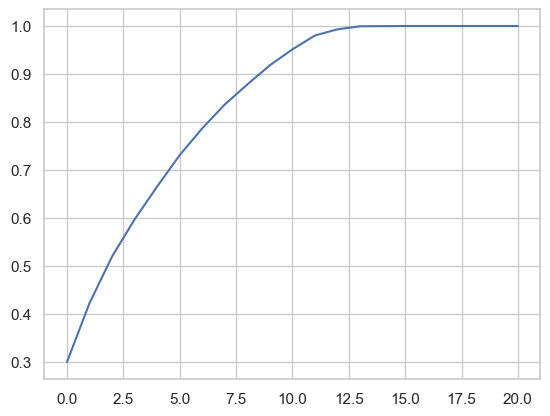

In [150]:
pca = PCA()
_ = pca.fit(agg_scaled)
cumsum = pca.explained_variance_ratio_.cumsum()
plt.plot(cumsum)

In [151]:
pca = PCA(n_components=10)
agg_pca = pca.fit_transform(agg_scaled)

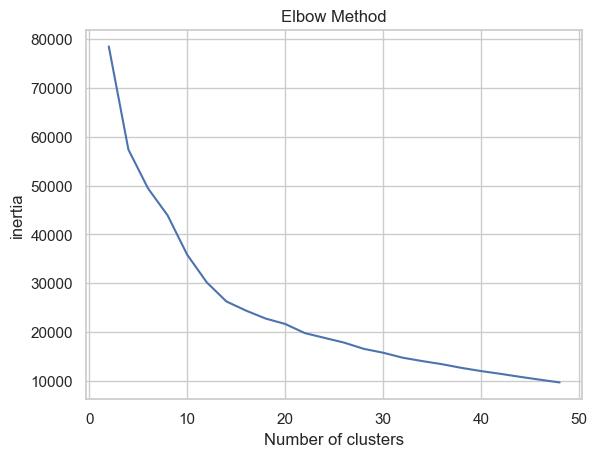

In [153]:
inertia = []
for i in range(2, 50, 2):
    kmeans = KMeans(n_clusters=i, max_iter=500,  random_state=42)
    kmeans.fit(agg_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 50, 2), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('inertia')
plt.show()

In [154]:
umap_model = umap.UMAP(n_components=2)
agg_umap = umap_model.fit_transform(agg_scaled)

/opt/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[1.12389271e-14 2.57769484e-07 3.58667085e-07 2.18008099e-05]
not reaching the requested tolerance 7.748603820800781e-07.
Use iteration 1546 instead with accuracy 
3.1771343114824358e-06.

  _, diffusion_map = lobpcg(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[2.69797868e-15 2.54609325e-07 2.78082368e-07 1.21758456e-05]
not reaching the requested tolerance 7.748603820800781e-07.
  _, diffusion_map = lobpcg(


In [156]:

kmeans = KMeans(n_clusters=14, max_iter=500,  random_state=42)
agg['cluster'] = kmeans.fit_predict(agg_scaled)

agg.head()



,Store_id,total_sales,avg_sales,total_orders,avg_orders,average_sales_per_order,sales_ratio_store_type,sales_ratio_store_location,sales_ratio_store_region,Store_Type_S1,...,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4,cluster
0,1,17904396.24,34698.442326,30508,59.124031,586.875450,0.005354,0.028239,0.023932,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,8
1,292,18231003.09,35331.401337,26524,51.403101,687.339884,0.005452,0.008814,0.024368,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
2,181,21900705.00,42443.226744,38593,74.792636,567.478688,0.018788,0.010589,0.123506,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7
3,264,23484270.87,45512.152849,35883,69.540698,654.467878,0.020147,0.011354,0.132437,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7
4,62,12618473.88,24454.406744,19956,38.674419,632.314787,0.015862,0.051498,0.016866,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4


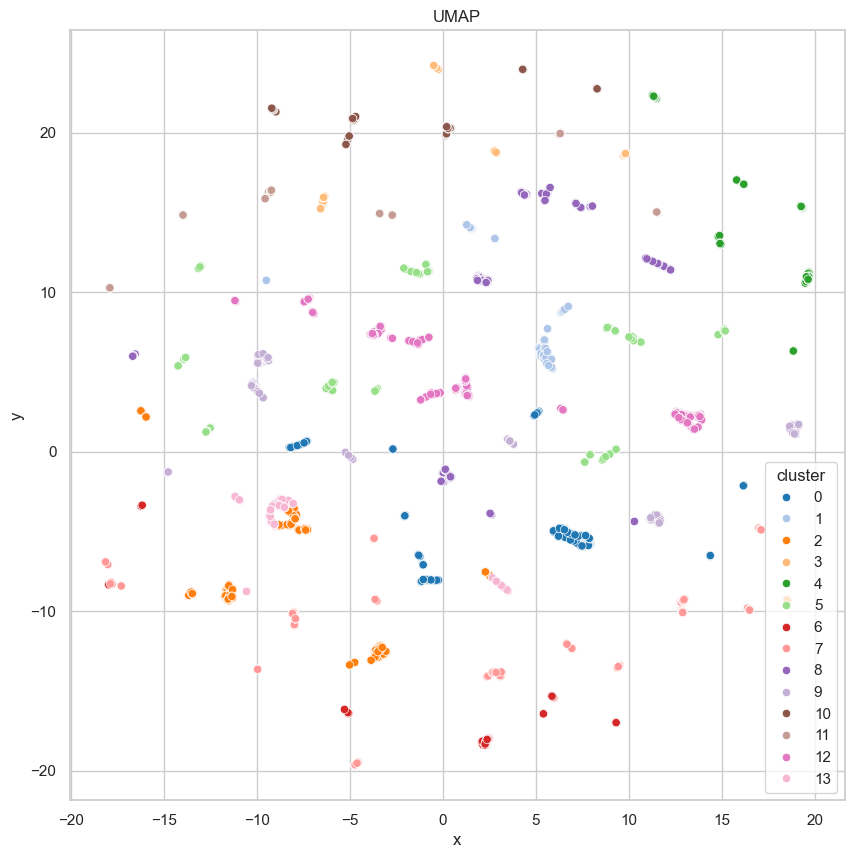

In [157]:
umap_df = pd.DataFrame(agg_umap, columns=['x', 'y'])
umap_df['cluster'] = agg['cluster']
plt.figure(figsize=(10, 10))
sns.scatterplot(data=umap_df, x='x', y='y', hue='cluster', palette='tab20')
plt.title('UMAP')
plt.show()